In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os
import sys


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import plotly.express as px

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities import utils


DATA_PATH = utils.get_datapath('data')
MODEL_PATH = utils.get_datapath('model')
FIGURE_PATH = utils.get_datapath('figures')

%load_ext autoreload
%autoreload 2

# **7. Model Evaluation**

We will now evaluate how the models performed by looking at different metrics for precision and recall. This notebook will first be split up based on the type of text representation, either TF-IDF or Ada embeddings. 

We will specifically look at the:
- Precsion 
- Recalll
- AUC-ROC



# Prepare Data

We will get the same train / test splits as the models were built with by using the same random state. 

In [2]:
# Load the data
df = pd.read_csv(DATA_PATH / 'clean_lyrics_final.csv')

In [3]:
X=df[['cleaned_lyrics_stem', 'ada_embeddings']]
y=df['spotify_popularity_three_class']

# Create train and test splits and set a random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=33)

# Dividing up the raws lyrics and the embeddings.
X_train_lyrics = X_train['cleaned_lyrics_stem']
X_train_embeddings = utils.get_ada_embeddings(X_train['ada_embeddings'])

X_test_lyrics = X_test['cleaned_lyrics_stem']
X_test_embeddings = utils.get_ada_embeddings(X_test['ada_embeddings'])


In [4]:
X_train_lyrics.shape, X_test_lyrics.shape

((22848,), (5712,))

In [5]:
X_train_embeddings.shape, X_test_embeddings.shape

((22848, 1536), (5712, 1536))

In [6]:
# Check the test 
y_test.value_counts(normalize=True)

1    0.338936
0    0.337885
2    0.323179
Name: spotify_popularity_three_class, dtype: float64

# Evaluating Models Trained on TF-IDF

## Logisitic Regression Alone

In [7]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf.pkl')

In [8]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### Classification Report

In [9]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.44      0.54      0.49      1930
         Med       0.38      0.30      0.34      1936
        High       0.42      0.41      0.42      1846

    accuracy                           0.42      5712
   macro avg       0.42      0.42      0.41      5712
weighted avg       0.42      0.42      0.41      5712



<Figure size 800x800 with 0 Axes>

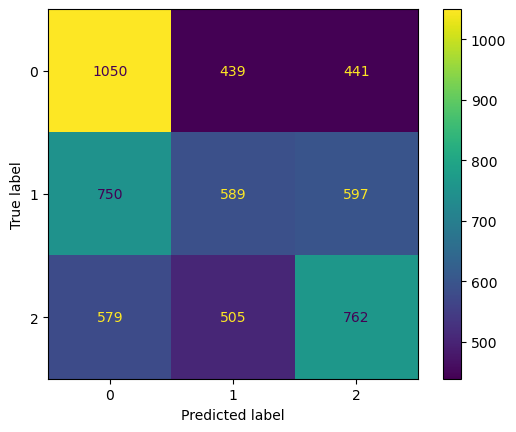

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [11]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

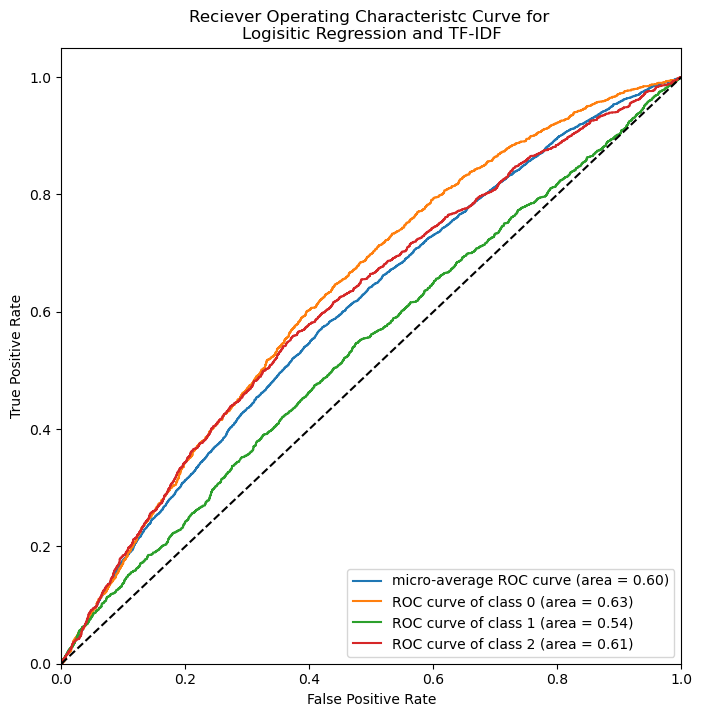

In [12]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and TF-IDF')

## Logisitic Regression + Dimensionality Reduction

In [38]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf_nmf.pkl')

In [39]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### Classification Report

In [40]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.42      0.56      0.48      1930
         Med       0.36      0.24      0.29      1936
        High       0.41      0.41      0.41      1846

    accuracy                           0.40      5712
   macro avg       0.40      0.40      0.39      5712
weighted avg       0.40      0.40      0.39      5712



### Confusion Matrix

<Figure size 800x800 with 0 Axes>

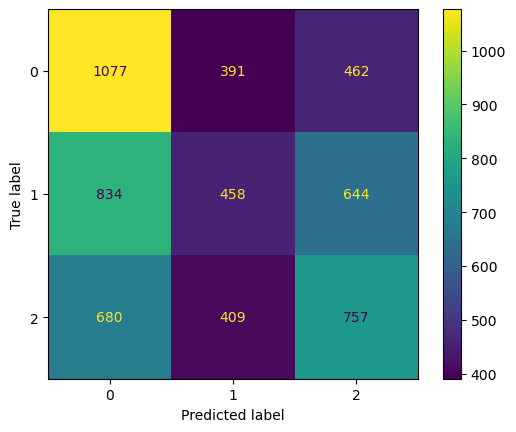

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [42]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

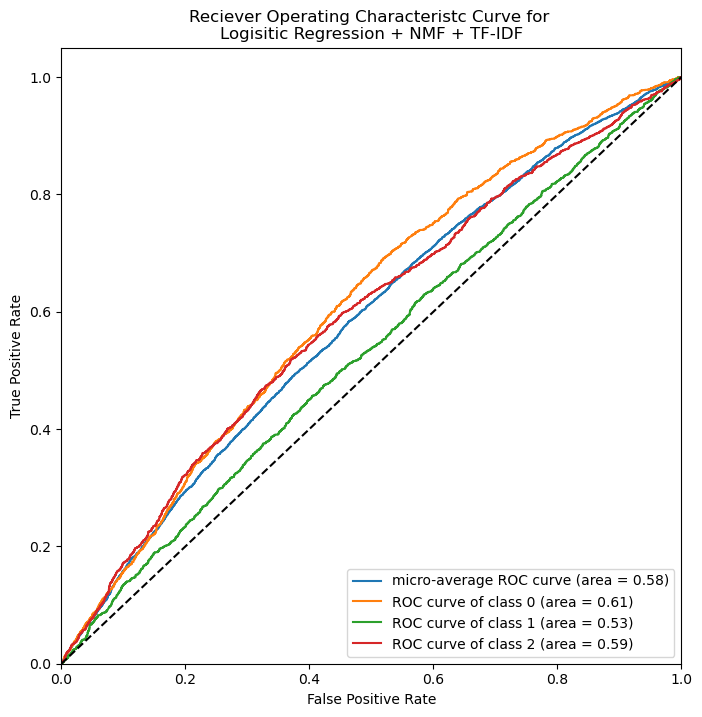

In [43]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression + NMF + TF-IDF')

The ROC curve seems to be similar with the model struggling the most to classify medium popularity songs. 

## Multinomial Naive Bayes Classifier

In [44]:
# Load the model
model = utils.load_model(MODEL_PATH / 'naive_bayes_tf_idf.pkl')

In [45]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### Classification Report

In [46]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.43      0.55      0.48      1930
         Med       0.39      0.23      0.29      1936
        High       0.42      0.48      0.45      1846

    accuracy                           0.42      5712
   macro avg       0.41      0.42      0.41      5712
weighted avg       0.41      0.42      0.41      5712



This Naive Bayes classifier demonstrated similar performance to the first logistic regression model. 

### Confusion Matrix

<Figure size 800x800 with 0 Axes>

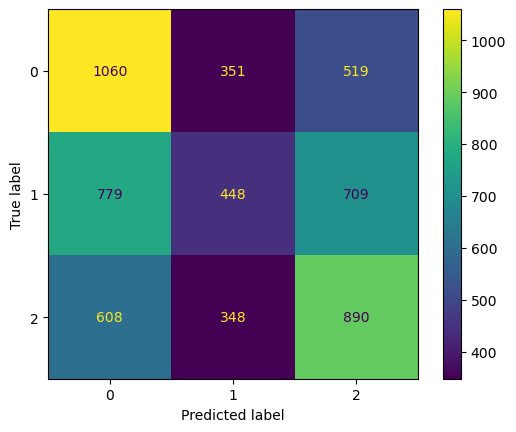

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [48]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

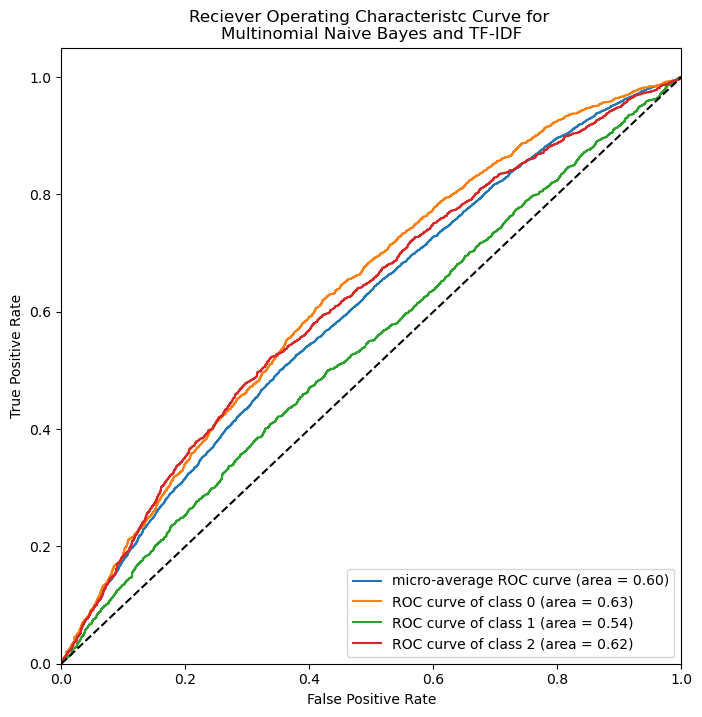

In [49]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Multinomial Naive Bayes and TF-IDF')

## Random Forest 

In [50]:
# Load the model
model = utils.load_model(MODEL_PATH / 'random_forest_tf_idf_v1.pkl')

In [51]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### Classification Report

In [52]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.42      0.63      0.51      1930
         Med       0.39      0.23      0.29      1936
        High       0.44      0.40      0.42      1846

    accuracy                           0.42      5712
   macro avg       0.42      0.42      0.41      5712
weighted avg       0.42      0.42      0.41      5712



### Confusion Matrix

<Figure size 800x800 with 0 Axes>

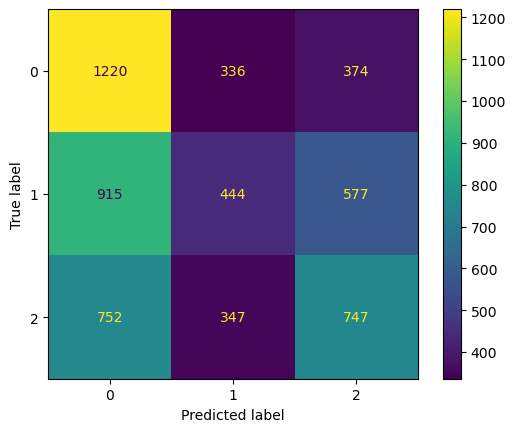

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [26]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

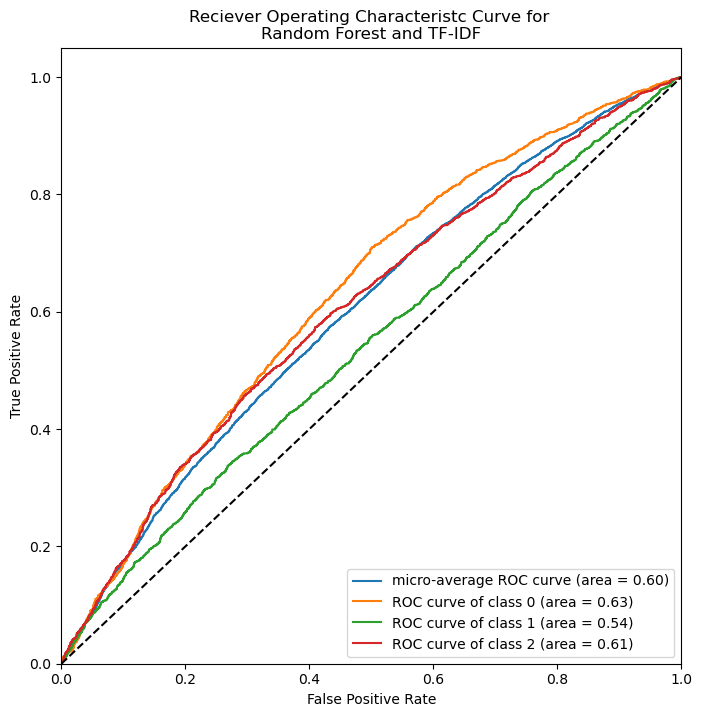

In [27]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Random Forest and TF-IDF')

---

# Evaluating Models Trained on Ada Embeddings

## Logsitic Regression

In [54]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_ada.pkl')

In [55]:
predictions = model.best_estimator_.predict(X_test_embeddings)

### Classification Report

In [56]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.45      0.68      0.54      1930
         Med       0.43      0.42      0.43      1936
        High       0.52      0.26      0.34      1846

    accuracy                           0.45      5712
   macro avg       0.47      0.45      0.44      5712
weighted avg       0.47      0.45      0.44      5712



A similar trend is observed between the precision and recall for the Ada embeddings when compared to TF-IDF.

### Confusion Matrix

<Figure size 800x800 with 0 Axes>

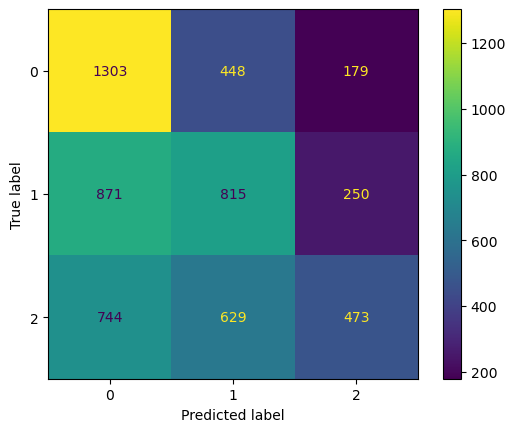

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [31]:
y_score = model.predict_proba(X_test_embeddings)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

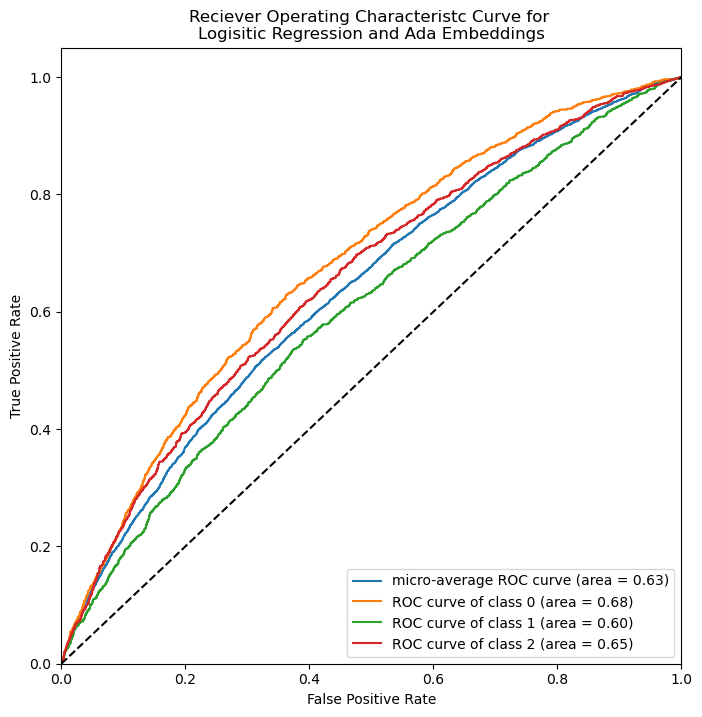

In [32]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and Ada Embeddings')

## Logsitic Regression and PCA Transformed Ada Embeddings

In [58]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_ada_pca.pkl')

In [59]:
predictions = model.best_estimator_.predict(X_test_embeddings)

### Classification Report

In [60]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.43      0.60      0.50      1930
         Med       0.40      0.23      0.29      1936
        High       0.43      0.44      0.43      1846

    accuracy                           0.42      5712
   macro avg       0.42      0.42      0.41      5712
weighted avg       0.42      0.42      0.41      5712



### Confusion Matrix

<Figure size 800x800 with 0 Axes>

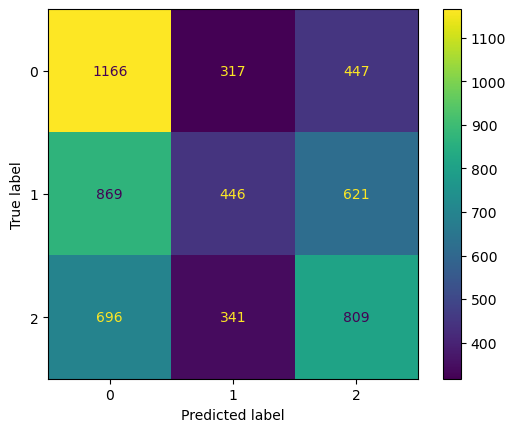

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [62]:
y_score = model.predict_proba(X_test_embeddings)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

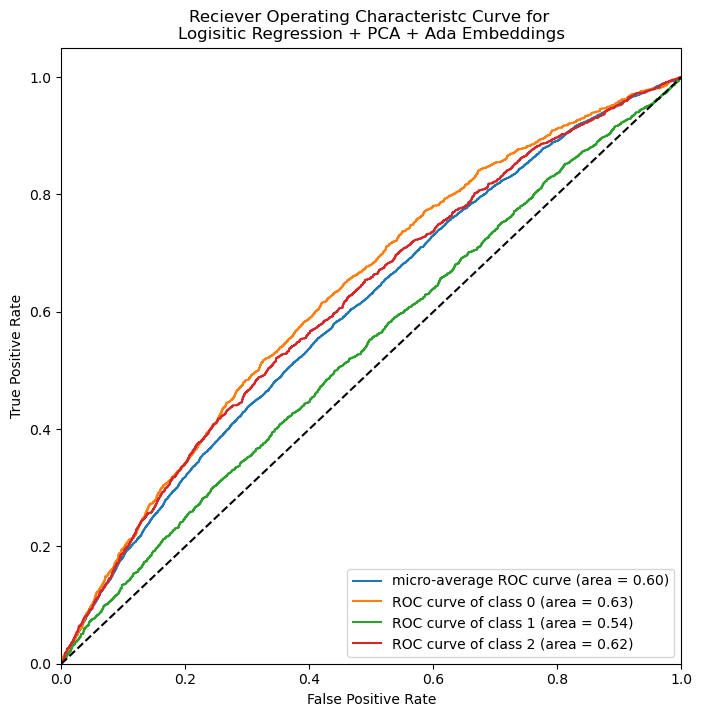

In [63]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression + PCA + Ada Embeddings')

# Evaluating Predictive Ability of Lyrics in Hip Hop

## Logistic Regression and TF-IDF

In [5]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf_hip_hop.pkl')

In [6]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### Classification Report

In [7]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.41      0.71      0.52      1930
         Med       0.44      0.24      0.31      1936
        High       0.47      0.33      0.39      1846

    accuracy                           0.43      5712
   macro avg       0.44      0.43      0.41      5712
weighted avg       0.44      0.43      0.41      5712



<Figure size 800x800 with 0 Axes>

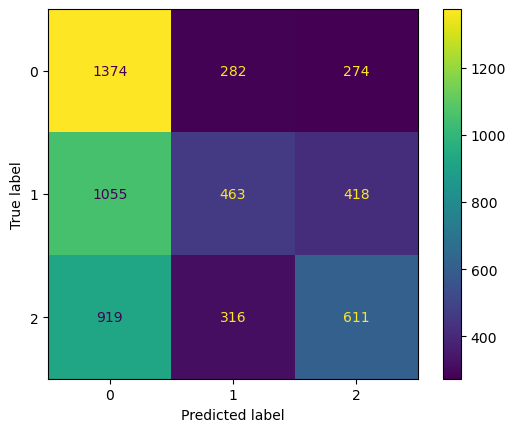

In [8]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [9]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

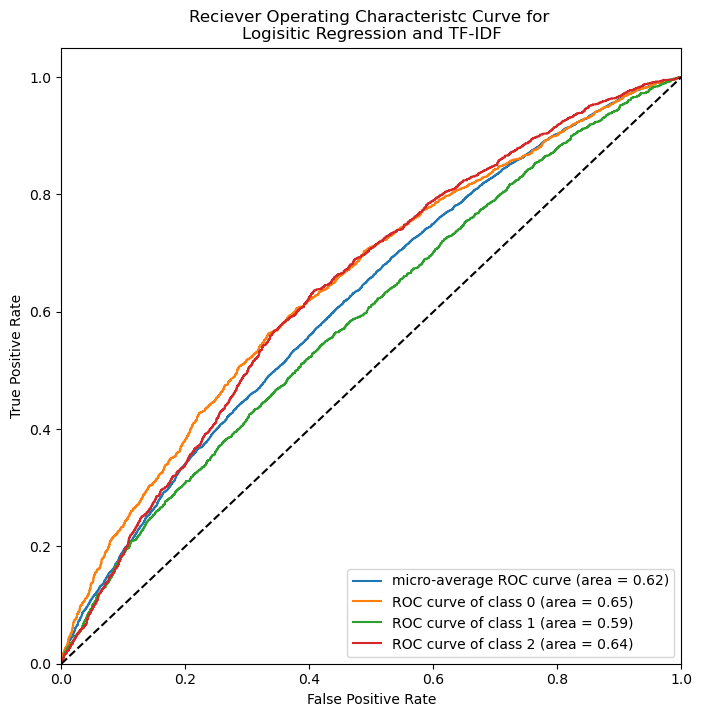

In [10]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and TF-IDF')

## Naive Bayers and TF-IDF

In [15]:
# Load the model
model = utils.load_model(MODEL_PATH / 'mnb_tfidf_hip_hop.pkl')

In [16]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### Classification Report

In [17]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.44      0.61      0.51      1930
         Med       0.45      0.26      0.33      1936
        High       0.46      0.48      0.47      1846

    accuracy                           0.45      5712
   macro avg       0.45      0.45      0.44      5712
weighted avg       0.45      0.45      0.43      5712



<Figure size 800x800 with 0 Axes>

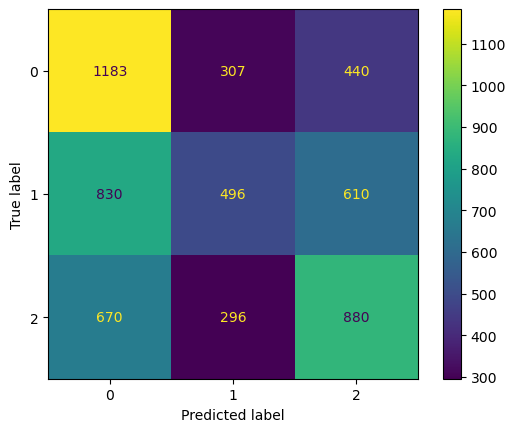

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### AUC-ROC Curve

In [19]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

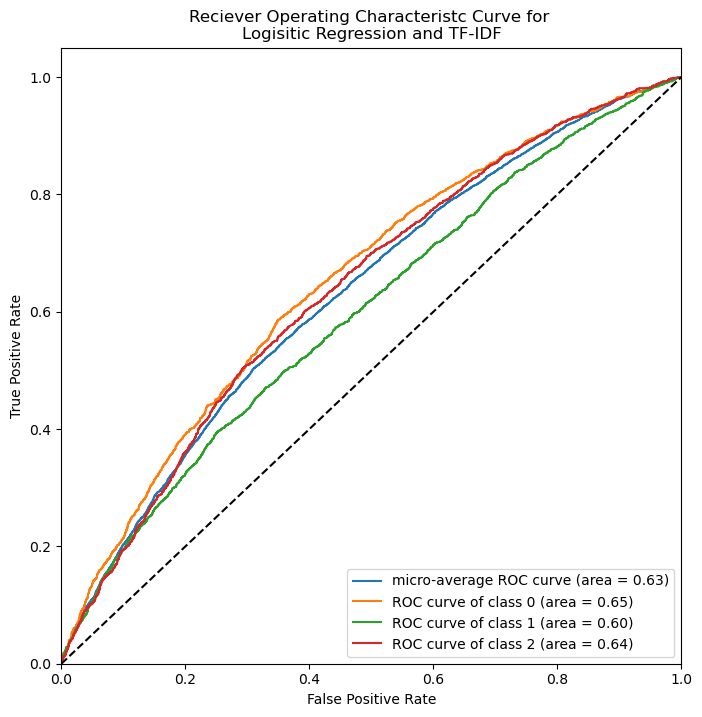

In [20]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and TF-IDF')

---

# Model Interpretation

After evaluating the model performance, we decided to try and see which words were weighted more heavily for predicting a songs popularity. We will mainly be focusing on interpreting the models that used the TF-IDF vectors as there is no easy way to interpret the document embeddings from OpenAI. Additionally, we will just look at the words that are most important for predicting `High` and `Low` popularity songs, as all the models have demonstrated poorer performance (AUC close to 0.5) for determining `Medium` popularity songs.

We wiil first look at the logisitic regression model and look at the top predicting words for each class based on the model coefficients. 

## Logsitc Regression and TF-IDF Model Interpretation

The first step for interpretation is to get the words that were used in the vectorizer. 

In [52]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf.pkl')

In [53]:
# Get the words in the vectorizer.
words = model.best_estimator_.named_steps['tfidf'].get_feature_names_out()

In [54]:
len(words)

2236

We see that there are 2236 tokens in the vectorizer. We also need to get the model coefficients.

In [55]:
coefficients = model.best_estimator_.named_steps['log_reg'].coef_

In [56]:
coefficients.shape

(3, 2236)

In [57]:
coefficients

array([[ 0.02581674,  0.28094972, -0.2379321 , ...,  0.09981127,
         0.00701805, -0.01167028],
       [-0.13652774, -0.10380281, -0.03213235, ..., -0.11781754,
         0.11486694,  0.07634035],
       [ 0.110711  , -0.1771469 ,  0.27006445, ...,  0.01800627,
        -0.12188498, -0.06467007]])

In [58]:
# The order of the classes for the coefficients.
model.best_estimator_.named_steps['log_reg'].classes_

array([0, 1, 2])

We can see that the model has coefficients for each of our three classes, which is demonstrated by the shape of the coefficients. This is the case as logistic regression for multi-class problems in scikit-learn create classifiers for each class. Each classifier treats the class as the positive class and the other classes as the negative class. This reduces the problem to a binary classification for each of the classifiers. 

We can still see which words are most important for determining each class by looking at the coefficients for each row in `coefficients`. 

### Word Importance for the Most Popular Songs

In [59]:
# Extract the songs for the most popular songs.
word_importance_most_popular_songs = pd.DataFrame(
    {
        'Word':words,
        'Coefficients':coefficients[2]
    }
).sort_values(by='Coefficients', ascending=False)

In [60]:
# Calculate the odds for each song. 
word_importance_most_popular_songs['Odds'] = np.exp(word_importance_most_popular_songs['Coefficients'])

In [61]:
word_importance_most_popular_songs[:20]

,Word,Coefficients,Odds
2213,yeah,0.417526,1.518201
672,feel,0.411589,1.509214
1280,need,0.407777,1.503471
1552,rememb,0.395063,1.484478
1329,ooh,0.394166,1.483147
1320,oh,0.373219,1.452402
917,hold,0.368025,1.444878
2107,wanna,0.367957,1.444780
104,bad,0.364590,1.439924
579,drunk,0.350519,1.419804


In [62]:
fig = px.bar(
    word_importance_most_popular_songs[:20],
    x='Word',
    y='Odds',
    width=600, height=600,
    template='xgridoff',
    title='<b>Top 20 Words For Predicting a Popular Song<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Odds<b>',
        xaxis_title='<b>Words<b>',
        showlegend=False,
        yaxis_range=[1.2, 1.6]

)

fig.show()

We can see that most of the words have positive feelings associated with them and many deal with physical contact (`feel`, `hold` and `kiss`). Additionally, certain words may look strange as they were stemmed, for example `remember` was turned into `remember`. Also mentioning `la`, which was originally `LA` (transformed during text cleaning stage), seems to also increase the popularity of a song. 

In [63]:
with open(FIGURE_PATH / 'Top_20_words_for_popular_songs.pkl', 'wb') as file:
    joblib.dump(fig, file)

### Word Importance for the Least Popular Songs

In [64]:
# Extract the coefficients for the least popular songs.
word_importance_least_popular_songs = pd.DataFrame(
    {
        'Word':words,
        'Coefficients':coefficients[0]
    }
).sort_values(by='Coefficients', ascending=False)

In [65]:
# Calculate the odds for each word. 
word_importance_least_popular_songs['Odds'] = np.exp(word_importance_least_popular_songs['Coefficients'])

In [66]:
word_importance_least_popular_songs[:20]

,Word,Coefficients,Odds
556,drake,0.793632,2.211413
1555,remix,0.639110,1.894793
2206,ya,0.604805,1.830895
1518,rapper,0.527801,1.695201
37,aint,0.527603,1.694865
966,imma,0.497864,1.645203
2204,x2,0.485299,1.624660
470,cuz,0.466855,1.594969
852,gucci,0.456691,1.578840
837,green,0.445998,1.562048


In [67]:
fig = px.bar(
    word_importance_least_popular_songs[:20],
    x='Word',
    y='Odds',
    width=600, height=600,
    template='xgridoff',
    title='<b>Top 20 Words For Predicting an Unpopular Song<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Odds<b>',
        xaxis_title='<b>Words<b>',
        showlegend=False,
        yaxis_range=[1.2, 2.2]

)

fig.show()

Shockingly we can see that mentioning `Drake` in a song increases the odds of the model classifying the song as an unpopular song. This could be attributed to inexperienced "Soundcloud Rappers" commenting on  `Drake` in their songs. This is supported as some of the other words that increase the odds of an unpopular song also are correlated to generic sounding novice rapper themes such as `money` and `green`. 

In [68]:
with open(FIGURE_PATH / 'Top_20_words_for_unpopular_songs.pkl', 'wb') as file:
    joblib.dump(fig, file)